Brownian Motion
===============

This is an attempt at a better understanding of our new metrics of molecular motion,
namely how they relate to each other when Brownian Dynamics are observed.
This notebook implements Brownian dynamics using the recipie from the [scipy cookbook]( http://scipy-cookbook.readthedocs.io/items/BrownianMotion.html),
then uses the simulation of Brownian motion to investigate
how the molecular relaxation times respond.

Implementation
--------------

The code in the cell below implements the brownian dynamics.
For 2D brownian dynamics, x0 with 2 elements can be used as the input. 

In [2]:
from math import sqrt
from scipy.stats import norm
import numpy as np

def brownian(x0, n, dt, delta, out=None):
    """Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

### Testing Brownian Dynamics

This is a simple test case of the function to Generate the Brownian dynamics
ensuring that the resulting trajectory is sensible,
and to give some idea of the spread of values.

In [3]:
import numpy
import matplotlib.pyplot as plt

# The Wiener process parameter.
delta = 0.25
# Total time.
T = 10.0
# Number of steps.
N = 1000
# Time step size
dt = T/N
# Initial values of x.
x = numpy.empty((2,N+1))
x[:, 0] = 0.0

brownian(x[:,0], N, dt, delta, out=x[:,1:])

# Plot the 2D trajectory.
plt.plot(x[0],x[1])

# Mark the start and end points.
plt.plot(x[0,0],x[1,0], 'go')
plt.plot(x[0,-1], x[1,-1], 'ro')

# More plot decorations.
plt.title('2D Brownian Motion')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axis('equal')
plt.grid(True)
plt.show()

<Figure size 640x480 with 1 Axes>

Dynamics Analysis
-----------------

Now we have a function to generate brownian dynamics,
I want to use it to  

In [4]:
from sdanalysis import dynamics
from numba import jit
nsteps = 1000
T = 40.0
delta_param = 0.25
num_mols = 2000


@jit
def get_relax():
    relax = []
    for mol in range(num_mols):
        delta = np.linalg.norm(brownian(np.zeros((2)), nsteps, T/nsteps, delta_param), axis=0)
        delta = delta.reshape((-1, 1))
        tau_F = dynamics.molecularRelaxation(1, 0.4)
        tau_L = dynamics.lastMolecularRelaxation(1, 0.4, 1.0)
        for time, dist in enumerate(delta):
            tau_F.add(time, dist)
            tau_L.add(time, dist)
        relax.append({
            'tau_L': tau_L.get_status()[0],
            'tau_F': tau_F.get_status()[0],
        })
    return relax
relax = get_relax()

In [5]:
import pandas
brownian_relation = pandas.DataFrame.from_records(relax)
brownian_relation = brownian_relation[brownian_relation.tau_L != 2**32-1]

In [6]:
import altair as alt
import altair.vegalite.v2 as vl
# vl.data_transformers.enable('json')

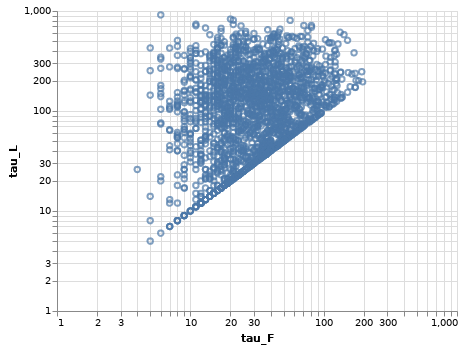

In [7]:
c = alt.Chart(brownian_relation).mark_point().encode(
    x=alt.X('tau_F', scale=alt.Scale(type='log')),
    y=alt.Y('tau_L', scale=alt.Scale(type='log')),
)
c

In [8]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()
x, y = 'tau_F', 'tau_L'
f = figure(x_axis_type='log', y_axis_type='log', x_axis_label=x, y_axis_label=y)
f.scatter(x, y, source=brownian_relation)
show(f)

Loading BokehJS ...

In [16]:
import itertools
import scipy.stats
df = brownian_relation[['tau_L', 'tau_F']]
df.reset_index(drop=True, inplace=True)
for x1, x2 in itertools.combinations(df.columns, 2):
    correlation, pValue = scipy.stats.pearsonr(getattr(df, x1), getattr(df, x2))
    print(f'{x1: <8} {x2: <8} {correlation:.2f}')

tau_L    tau_F    0.18


In [17]:
# hist, vals = np.histogram(brownian_relation.tau_L - brownian_relation.tau_F, normed=True)

In [18]:
# brownian_relation['diff'] = brownian_relation.tau_L - brownian_relation.tau_F
# with np.errstate(divide='ignore'):
#     brownian_relation['log_diff'] = np.log10(brownian_relation.tau_L - brownian_relation.tau_F)
# brownian_relation['log_tau_L'] = np.log10(brownian_relation.tau_L)
# brownian_relation['log_tau_S'] = np.log10(brownian_relation.tau_F)

In [86]:
brownian_relation = brownian_relation[['tau_L', 'tau_F']]
brownian_relation['dataset'] = 'Brownian'

lowT_df = pandas.read_hdf('../data/processed/trajectory-13.50-1.35.hdf5', 'relaxations')[['tau_DL04', 'tau_D04']]
lowT_df.columns = ['tau_L', 'tau_F']
lowT_df['dataset'] = 'Low T'

highT_df = pandas.read_hdf('../data/processed/trajectory-13.50-2.50.hdf5', 'relaxations')[['tau_DL04', 'tau_D04']]
highT_df.columns = ['tau_L', 'tau_F']
highT_df['dataset'] = 'High T'

num_samples = 1300 #len(brownian_relation)
df = pandas.concat([brownian_relation.sample(num_samples), lowT_df.sample(num_samples), highT_df.sample(num_samples)])
df.reset_index(drop=True, inplace=True)

In [87]:
num_bins = 6
log_tau_F = np.log10(df.tau_F)
df['log_tau_F'] = log_tau_F
values, bins = np.histogram(log_tau_F, normed=True, bins=num_bins)
str_bins = [f'{bin:.2f}' for bin in bins]
tau_F_index = np.digitize(log_tau_F-1, bins)
df['log_tau_F_value'] = np.take(str_bins, tau_F_index)
factor = pandas.Series(np.ones(len(df)))
for i, group in df.groupby(['dataset', 'log_tau_F_value']):
     factor[group.index] = len(group)
df['factor'] = 1/factor
df['logDiff'] = np.log(datum.tau_L - datu)

NameError: name 'datum' is not defined

In [ ]:
c = alt.Chart(df).mark_line().encode(
    x=alt.X('log_diff:Q', axis=alt.Axis(title='log(τ_L - τ_F)'), bin=alt.Bin(maxbins=40)),
    y=alt.Y('count(tau_F_binned):Q', axis=alt.Axis(title='Probability'), stack=None),
    color=alt.Color('tau_F_binned:N', legend=alt.Legend(title='log(τ_F)', values=str_bins)),
    column=alt.Column('dataset', header=alt.Header(title='Dataset')),
).transform_calculate(
    'log_diff', "datum.tau_L == datum.tau_F ? NaN : log(datum.tau_L + datum.tau_F) / LN10"
).transform_calculate(
    'log_tau_F', 'log(datum.tau_F) / LN10'
).transform_bin(
    **{'bin': True, 'field': '', 'as': 'tau_F_binned'}
)
c

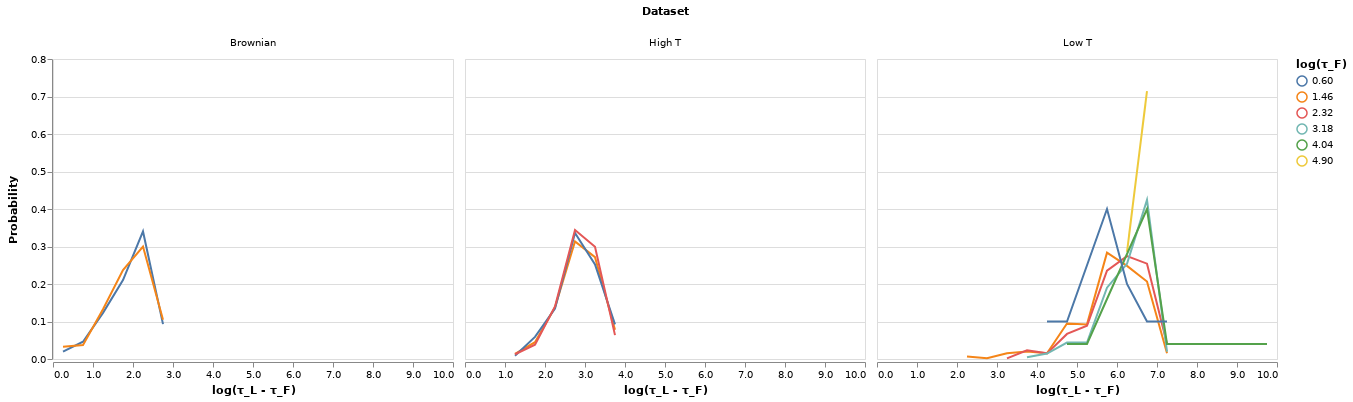

In [89]:
c = alt.Chart(df).mark_line().encode(
    x=alt.X('log_diff:Q', axis=alt.Axis(title='log(τ_L - τ_F)'), bin=alt.Bin(maxbins=40)),
    y=alt.Y('sum(factor)', axis=alt.Axis(title='Probability'), stack=None),
    color=alt.Color('log_tau_F_value:N', legend=alt.Legend(title='log(τ_F)')),
    column=alt.Column('dataset', header=alt.Header(title='Dataset')),
).transform_calculate(
    'log_diff', "datum.tau_L == datum.tau_F ? NaN : log(datum.tau_L - datum.tau_F) / LN10"
)
c